# 사전 작업

## 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc

In [25]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 400)

# 이상치 없는 데이터

## 데이터 로드

In [4]:
path = './data/'

In [10]:
train = pd.read_csv(path + 'train_v2.csv')
test = pd.read_csv(path + 'test_v2.csv')

In [13]:
train = train[train.outliers == 0]

## 제거할 피처

In [14]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## Parameter

In [15]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

## training model

In [19]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60488	valid_1's rmse: 1.61672
[200]	training's rmse: 1.57256	valid_1's rmse: 1.58959
[300]	training's rmse: 1.55697	valid_1's rmse: 1.57874
[400]	training's rmse: 1.54665	valid_1's rmse: 1.57308
[500]	training's rmse: 1.53847	valid_1's rmse: 1.56948
[600]	training's rmse: 1.53136	valid_1's rmse: 1.5673
[700]	training's rmse: 1.5252	valid_1's rmse: 1.56578
[800]	training's rmse: 1.51956	valid_1's rmse: 1.56474
[900]	training's rmse: 1.51443	valid_1's rmse: 1.56397
[1000]	training's rmse: 1.50961	valid_1's rmse: 1.56353
[1100]	training's rmse: 1.50501	valid_1's rmse: 1.56313
[1200]	training's rmse: 1.50057	valid_1's rmse: 1.56279
[1300]	training's rmse: 1.49636	valid_1's rmse: 1.56255
[1400]	training's rmse: 1.49207	valid_1's rmse: 1.5624
[1500]	training's rmse: 1.48794	valid_1's rmse: 1.56218
[1600]	training's rmse: 1.48391	valid_1's rmse: 1.56205
[1700]	training's rmse: 1.47994	valid_1's rm

[2200]	training's rmse: 1.46036	valid_1's rmse: 1.56154
[2300]	training's rmse: 1.45661	valid_1's rmse: 1.5615
[2400]	training's rmse: 1.4531	valid_1's rmse: 1.56139
[2500]	training's rmse: 1.44949	valid_1's rmse: 1.56142
[2600]	training's rmse: 1.44586	valid_1's rmse: 1.56134
[2700]	training's rmse: 1.44234	valid_1's rmse: 1.56132
[2800]	training's rmse: 1.43878	valid_1's rmse: 1.56128
[2900]	training's rmse: 1.43536	valid_1's rmse: 1.56124
[3000]	training's rmse: 1.43192	valid_1's rmse: 1.56124
[3100]	training's rmse: 1.42846	valid_1's rmse: 1.56128
[3200]	training's rmse: 1.42502	valid_1's rmse: 1.56125
[3300]	training's rmse: 1.42167	valid_1's rmse: 1.56124
Early stopping, best iteration is:
[3159]	training's rmse: 1.4264	valid_1's rmse: 1.5612


NameError: name 'oof_lgb_3' is not defined

In [21]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb

# 이상치 예측 모델

## 데이터 로드

In [22]:
train = pd.read_csv(path + 'train_v2.csv')
test = pd.read_csv(path + 'test_v2.csv')

In [23]:
target = train['outliers']

## 제거할 피처

In [24]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [27]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [31]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439766	valid_1's binary_logloss: 0.0466665
[200]	training's binary_logloss: 0.0439966	valid_1's binary_logloss: 0.0466482
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0439433	valid_1's binary_logloss: 0.0467616
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.043985	valid_1's binary_logloss: 0.0471713
[200]	training's binary_logloss: 0.0440124	valid_1's binary_logloss: 0.0471722
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0440217	valid_1's binary_logloss: 0.0470251
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.04429	valid_1's binary_logloss: 0.046208
[200]	training's binary_logloss: 0.044373	valid_1's binary_logloss: 0.0463012
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.044278	valid_1's bina

ValueError: Unknown label type: (array([0.00185538, 0.01493974, 0.00208452, ..., 0.00468058, 0.01714252,
       0.00185538]),)

In [39]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb
outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.095006
1,C_ID_130fd0cbdd,0.001793
2,C_ID_b709037bc5,0.006206
3,C_ID_d27d835a9f,0.001715
4,C_ID_2b5e3df5c2,0.002374


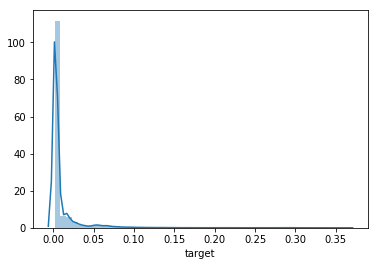

In [71]:
sns.distplot(outlier_prob.sort_values('target')['target'])

In [77]:
outt = outlier_prob.sort_values('target')[-10:].card_id

In [61]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])

In [49]:
best_submission = pd.read_csv(path + 'submission_best_score.csv')

In [44]:
most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.897076
1,C_ID_6d8dba8475,-0.808007
2,C_ID_7f1041e8e1,-5.447275
3,C_ID_22e4a47c72,-0.088087
4,C_ID_b54cfad8b2,-0.996847


In [56]:
for card_id in outlier_id['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = -33

In [45]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [60]:
model_without_outliers.to_csv("./data/combining_submission.csv", index=False)

In [72]:
subbb = pd.read_csv(path + 'submission_combining.csv')

In [74]:
subbb

,card_id,target
0,C_ID_0ab67a22ab,-2.897076
1,C_ID_130fd0cbdd,-0.218844
2,C_ID_b709037bc5,-0.295622
3,C_ID_d27d835a9f,-0.122080
4,C_ID_2b5e3df5c2,-1.369583
5,C_ID_5814b4f13c,0.847385
6,C_ID_a1b3c75277,0.187328
7,C_ID_f7cada36d3,0.899611
8,C_ID_9d2bc8dfc4,-0.734100
9,C_ID_6d8dba8475,-0.808007


In [78]:
for card_id in outt:
        subbb.loc[subbb['card_id']==card_id,'target'] = -33

In [80]:

subbb.to_csv('./data/submission_combining3.csv')